In [1]:
using Distributions
using StatsPlots
default(fmt=:png, titlefontsize=10, size=(400, 250))

In [2]:
function pvalue_clopper_pearson(n, k, p)
    bin = Binomial(n, p)
    min(1, 2cdf(bin, k), 2ccdf(bin, k-1))
end

function confint_clopper_pearson(n, k; α=0.05)
    p_L = k > 0 ? quantile(Beta(k, n-k+1), α/2) : zero(α)
    p_U = k < n ? quantile(Beta(k+1, n-k), 1-α/2) : one(α)
    [p_L, p_U]
end

function pvalue_wilson(n, k, p)
    p̂ = k/n
    SE = √(p*(1-p)/n)
    2ccdf(Normal(), abs(p̂ - p)/SE)
end

function confint_wilson(n, k; α=0.05)
    p̂ = k/n
    z = quantile(Normal(), 1-α/2)
    a, b, c = 1+z^2/n, p̂+z^2/(2n), p̂^2
    # ap² - 2bp + c = 0 を解く.
    sqrtD = √(b^2 - a*c)
    p_L = (b - sqrtD)/a
    p_U = (b + sqrtD)/a
    [p_L, p_U]
end

function pvalue_bayesian(n, k, p; prior=(1/2, 1/2))
    beta = Beta((prior .+ (k, n-k))...)
    min(1, 2cdf(beta, p), 2ccdf(beta, p))
end

function credint_bayesian(n, k; α=0.05, prior=(1/2, 1/2))
    beta = Beta((prior .+ (k, n-k))...)
    quantile.(beta, [α/2, 1-α/2])
end

function show_cis(n, k; α=0.05, prior=(1/2, 1/2),
        s=Bool[1,1,0], legend=:topleft)
    ci_ba = credint_bayesian(n, k; α, prior)
    ci_wi = confint_wilson(n, k; α)
    ci_cp = confint_clopper_pearson(n, k; α)
    beta0 = Beta(prior...)
    beta = Beta((prior .+ (k, n-k))...)
    prob_ci_ba = cdf(beta, ci_ba[end]) - cdf(beta, ci_ba[begin])
    prob_ci_wi = cdf(beta, ci_wi[end]) - cdf(beta, ci_wi[begin])
    prob_ci_cp = cdf(beta, ci_cp[end]) - cdf(beta, ci_cp[begin])
    if s[1]
        @show ci_ba
        @show prob_ci_ba
    end
    if s[2]
        @show ci_wi
        @show prob_ci_wi
    end
    if s[3]
        @show ci_cp
        @show prob_ci_cp
    end
    
    P1 = plot(; legend)
    plot!(beta; label="posterior", c=1)
    plot!(beta0; label="prior", ls=:dot, c=:black)
    title!("prior and posterior")
    
    P2 = plot()
    s[1] && plot!(p -> pvalue_bayesian(n, k, p; prior); label="Bayes", c=1)
    s[2] && plot!(p -> pvalue_wilson(n, k, p); label="Wilson", c=2, ls=:dash)
    s[3] && plot(p -> pvalue_clopper_pearson(n, k, p), 0, 1; label="CP", c=3, ls=:dashdot)
    title!("P-value functions")
    plot(P1, P2; size=(800, 250))
end

show_cis (generic function with 1 method)

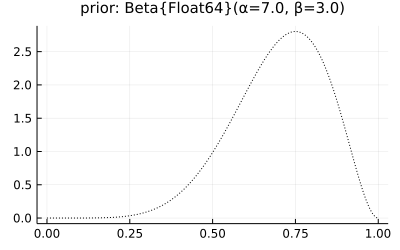

In [3]:
prior = (7, 3)
beta0 = Beta(prior...)
plot(beta0; label="", title="prior: $beta0", ls=:dot, c=:black)

ci_ba = [0.39025744042757865, 0.8907365561809019]
prob_ci_ba = 0.95
ci_wi = [0.09453120573423049, 0.9054687942657695]
prob_ci_wi = 0.9847106318745158


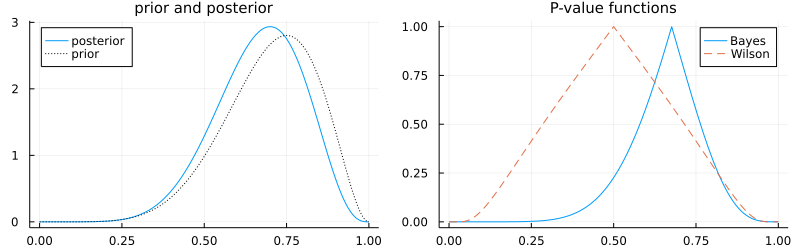

In [4]:
show_cis(2, 1; prior)

ci_ba = [0.3857383382492947, 0.8614206611098394]
prob_ci_ba = 0.95
ci_wi = [0.1500389891521492, 0.8499610108478508]
prob_ci_wi = 0.9657853607449298


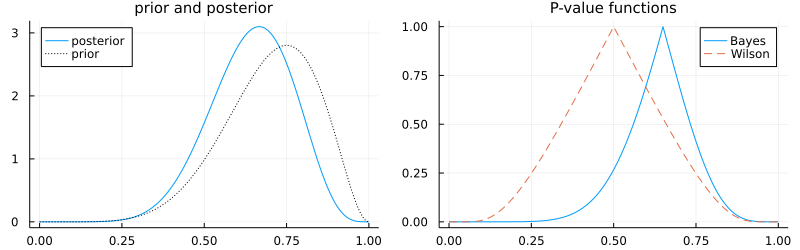

In [5]:
show_cis(4, 2; prior)

ci_ba = [0.38357792331440527, 0.7974785610228372]
prob_ci_ba = 0.95
ci_wi = [0.23659309051256366, 0.7634069094874364]
prob_ci_wi = 0.9413263743031158


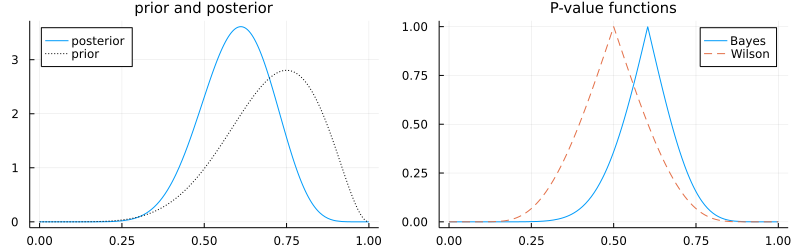

In [6]:
show_cis(10, 5; prior)

ci_ba = [0.3893627913969062, 0.7355446962932952]
prob_ci_ba = 0.9500000000000002
ci_wi = [0.299298008198212, 0.7007019918017879]
prob_ci_wi = 0.9346256340899142


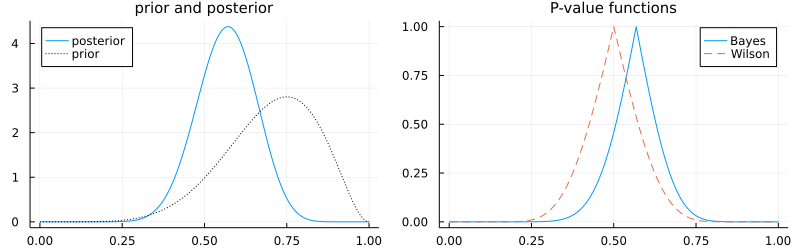

In [7]:
show_cis(20, 10; prior)

ci_ba = [0.4023054391098783, 0.6746612748834462]
prob_ci_ba = 0.9499999999999998
ci_wi = [0.3519952693346535, 0.6480047306653465]
prob_ci_wi = 0.9365363937680106


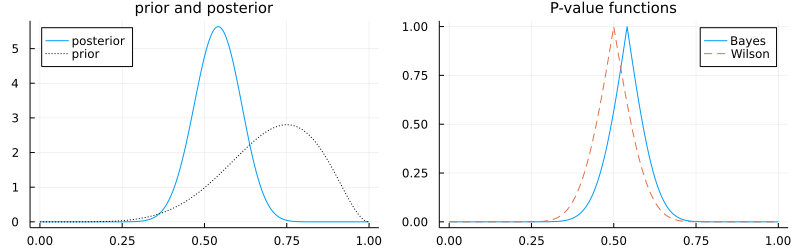

In [8]:
show_cis(40, 20; prior)

ci_ba = [0.419372402750547, 0.6241360763706899]
prob_ci_ba = 0.95
ci_wi = [0.3929741508611971, 0.6070258491388029]
prob_ci_wi = 0.9410418309217702


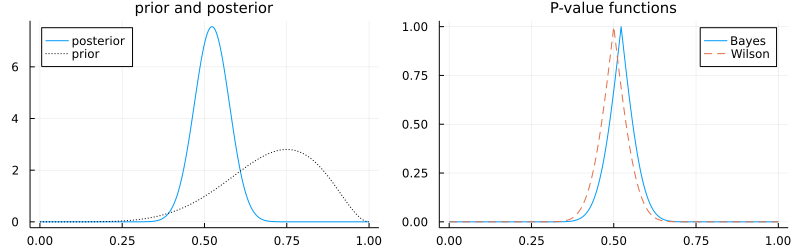

In [9]:
show_cis(80, 40; prior)

ci_ba = [0.4368072552078451, 0.5864598862856629]
prob_ci_ba = 0.9500000000000001
ci_wi = [0.4234392476991225, 0.5765607523008776]
prob_ci_wi = 0.9448130732388026


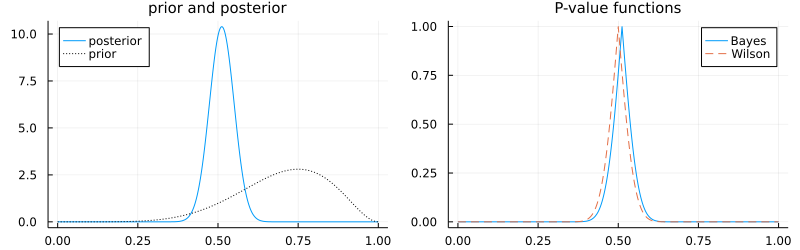

In [10]:
show_cis(160, 80; prior)

ci_ba = [0.45219966557857744, 0.5598519550651946]
prob_ci_ba = 0.9500000000000001
ci_wi = [0.4455432308355753, 0.5544567691644247]
prob_ci_wi = 0.9472054380954635


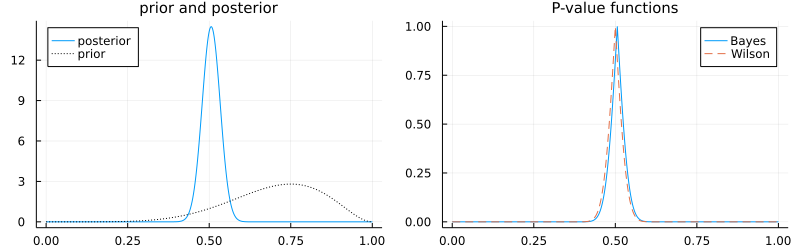

In [11]:
show_cis(320, 160; prior)

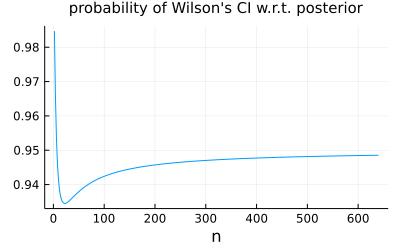

In [12]:
function prob_ci_wilson(n, k; α=0.05, prior=(1/2, 1/2))
    beta = Beta((prior .+ (k, n-k))...)
    ci = confint_wilson(n, k; α)
    cdf(beta, ci[end]) - cdf(beta, ci[begin])
end
plot(2:2:640, n -> prob_ci_wilson(n, n÷2; prior); label="")
title!("probability of Wilson's CI w.r.t. posterior")
plot!(xguide="n")